In [1]:
import pandas as pd
import numpy as np
import spacy as pac
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("C:\\datasources\\totsNER.csv", sep='|', encoding='utf-8')
df.head(2)

,Title,tags,quote,description,Links,cpub,PublicationDate,wtkURL,ArticleId,Priority,Summary_ref_links,Note_links,NERs,NERsMod
0,Who killed Martin Luther King Jr.? His family ...,"['governmentcorruption', ' civilliberties', ' ...","a Memphis jury ruled that the local, state and...",In the five decades since Martin Luther King J...,https://www.washingtonpost.com/news/retropolis...,Washington Post,2018-03-30,https://www.wanttoknow.info/a-who-killed-marti...,9369,94,['https://www.personalgrowthcourses.net/video/...,['https://www.personalgrowthcourses.net/video/...,"[('2006', 'DATE'), ('J. Edgar Hoover - laid', ...","{'2006': 'DATE', 'J. Edgar Hoover': 'PERSON', ..."
1,Are you ready? This is all the data Facebook a...,"['privacy', ' corporatecorruption']",Google offers an option to download all of the...,[Here's] how much of your information ... Face...,https://www.theguardian.com/commentisfree/2018...,The Guardian,2018-03-29,https://www.wanttoknow.info/a--you-ready-this-...,9367,92,"['https://www.google.com/maps/timeline?pb', ' ...",['https://www.wanttoknow.info/corporatecorrupt...,"[('5.5GB', 'MONEY'), ('first', 'ORDINAL'), ('M...","{'5.5GB': 'MONEY', 'first': 'ORDINAL', 'MB': '..."


In [2]:
#read in preprocessed companies file
dfENTed = pd.read_csv("C:\\datasources\\identcos.csv", sep='|', encoding='utf-8')
dfENTed[['InText', 'E_Type']] = dfENTed['InText'].str.split(':', expand=True)
dfENTed['E_Type'] = dfENTed['E_Type'].astype(str).apply(lambda fx: fx.replace('ORG', 'CORP'))

#combine with people and orgs files
pplst = pd.read_csv("C:\\datasources\\identpeople.csv", sep='|', encoding='utf-8')
orglst = pd.read_csv("C:\\datasources\\identorgs.csv", sep='|', encoding='utf-8')
dftemp = pd.concat([pplst, orglst])
dftemp[['InText', 'E_Type']] = dftemp['InText'].str.split(':', expand=True)
dfENTed = pd.concat([dfENTed, dftemp])
dfENTed = dfENTed.drop_duplicates(subset=['InText'])

#make reference list of entities to look for
usefulents = list(dfENTed['InText'].astype(str).values)

#clean up ent list in NERseek column
eseek = []
entedgekeys = []
entedgevals = []
for i in df['NERsMod'].astype(str).values:
    testk = []
    testv = []
    i = re.sub(", ", " | ", i)
    i = re.sub(",", "", i)
    i = re.sub("{", "", i)
    i = re.sub("}", "", i)
    i = i.split(" | ")
    for d in i:
        d = d.split(":")
        k = d[::2]
        testk.append(k)    
    eseek.append(testk)
esk = pd.Series(eseek)
df['NERseek'] = esk.values
nents = []
lols = df['NERseek'].astype(str).values
ticks = 0
for it in lols:
    indi = ticks + 1
    it = re.sub("\[", "", it)
    it = re.sub("\]", "", it)
    it = re.sub("\"", "", it)
    it = it.split(", ")
    keep = []
    for u in it:
        if u in usefulents:
            keep.append(u)
            entedgekeys.append(indi)
            entedgevals.append(u)
    if len(keep) < 1:
        keep.append("None Detected")
    nents.append(keep)
    ticks = ticks + 1
nesk = pd.Series(nents)
df['NERseek'] = nesk.values

eedges = list(zip(entedgekeys, entedgevals))
EEdgeDF = pd.DataFrame(eedges, columns=['From', 'To'])

#adjust From column value to match main df row index
EEdgeDF['From'] = EEdgeDF['From'] - 1
EEdgeDF.head(6)

,From,To
0,0,'J. Edgar Hoover'
1,0,'James Earl Ray'
2,0,'Martin Luther King Jr.'
3,0,'Martin Luther King'
4,1,'Google'
5,1,'Facebook'


In [3]:
#map titles to edge From column
cnct = pd.Series(df.Title.values,index=df.index).to_dict()
EEdgeDF['From'] = EEdgeDF['From'].map(cnct)
EEdgeDF.head(7)

,From,To
0,Who killed Martin Luther King Jr.? His family ...,'J. Edgar Hoover'
1,Who killed Martin Luther King Jr.? His family ...,'James Earl Ray'
2,Who killed Martin Luther King Jr.? His family ...,'Martin Luther King Jr.'
3,Who killed Martin Luther King Jr.? His family ...,'Martin Luther King'
4,Are you ready? This is all the data Facebook a...,'Google'
5,Are you ready? This is all the data Facebook a...,'Facebook'
6,Orlando nightclub shooter’s father was FBI inf...,'Seddique Mateens'


In [4]:
#resolve entity names to deduplicate
eresolve = pd.Series(dfENTed.Entity.values,index=dfENTed.InText.values).to_dict()
EEdgeDF['To'] = EEdgeDF['To'].map(eresolve)
EEdgeDF.head(7)

,From,To
0,Who killed Martin Luther King Jr.? His family ...,J. Edgar Hoover
1,Who killed Martin Luther King Jr.? His family ...,James Earl Ray
2,Who killed Martin Luther King Jr.? His family ...,Martin Luther King Jr
3,Who killed Martin Luther King Jr.? His family ...,Martin Luther King Jr
4,Are you ready? This is all the data Facebook a...,Google
5,Are you ready? This is all the data Facebook a...,Facebook
6,Orlando nightclub shooter’s father was FBI inf...,Seddique Mateen


In [5]:
#read in topic tag edges
taged = pd.read_csv("C:\\datasources\\tagedges.csv", sep='|', usecols=['ArticleId','tag'], encoding='utf-8')

#select which articles to include by topic tag
use = ['financial', 'incomeinequality', 'bankbailout']
taged = taged[taged['tag'].isin(use)]
idgroup = taged['ArticleId'].unique()
df = df[df['ArticleId'].isin(idgroup)]

#filter selection to only include articles connected to identified entities
use2 = EEdgeDF['From'].unique()
df = df[df['Title'].isin(use2)]

#cut the oldest articles
df = df.reset_index(drop=True)
df.drop(df.index[741:], inplace=True)

#cut the lowest rated articles
df.sort_values(by='Priority', ascending=False, inplace=True)
df = df.reset_index(drop=True)
df.drop(df.index[734:], inplace=True)

#do some final source deduplication and update mediacondense for next time  
df['cpub'] = df['cpub'].astype(str).apply(lambda r: r.replace('MarketWatch.com', 'MarketWatch'))
df['cpub'] = df['cpub'].astype(str).apply(lambda r: r.replace('Fox News', 'FOX'))
df['cpub'] = df['cpub'].astype(str).apply(lambda r: r.replace('BloombergBusinessweek', 'Bloomberg'))
df['cpub'] = df['cpub'].astype(str).apply(lambda r: r.replace('The Globe and Mail', 'Globe and Mail'))

#filter out least reliable or most opinionated sources
cutlist = ['Daily Mail', 'Alternet', 'Huffington Post', 'Truthout', 'New York Daily News', 'New York Post', 'Salon.com', 'Yes! Magazine']
df.update("'" + df['cpub'].astype(str) + "'")
df = df[~df['cpub'].isin(cutlist)]
df['cpub'] = df['cpub'].astype(str).apply(lambda r: r.replace("'", ''))

#filter entities edge list to only include entities connected to included articles
useEE = df['Title'].unique()
EEdgeDF = EEdgeDF[EEdgeDF['From'].isin(useEE)]

df.head(6)

,Title,tags,quote,description,Links,cpub,PublicationDate,wtkURL,ArticleId,Priority,Summary_ref_links,Note_links,NERs,NERsMod,NERseek
0,The War On Waste,"['war', ' governmentcorruption', ' financial',...","""According to some estimates we cannot track $...","On Sept. 10 [2001], Secretary of Defense Donal...",http://www.cbsnews.com/stories/2002/01/29/even...,CBS,2002-01-29,https://www.wanttoknow.info/a-2.3-trilliions-m...,846,97,[''],['http://www.personalgrowthcourses.net/video/t...,"[('\r\n ', 'ORG'), ('more than $48 billion', ...","{'Nothing': 'ORG', 'more than 48 billion': 'MO...","['Rumsfeld', 'Inspector General', 'Donald Rums..."
1,How can it be that you pay more to the IRS tha...,"['incomeinequality', ' governmentcorruption', ...",GE Capital has displayed an uncanny ability to...,"Some of the world's biggest, most profitable c...",http://www.forbes.com/2010/04/01/ge-exxon-walm...,Forbes,2010-04-01,https://www.wanttoknow.info/a-how-can-it-be-yo...,3077,96,[''],['http://www.wanttoknow.info/financialnewsarti...,"[('$1.1 billion', 'MONEY'), ('two', 'CARDINAL'...","{'1.1 billion': 'MONEY', 'two': 'CARDINAL', 't...","['GE', 'General Electric']"
2,Has Our Government Spent $21 Trillion Of Our M...,"['governmentcorruption', ' secrecy', ' financi...",Given that the entire Army budget in fiscal ye...,"On July 26, 2016, the Office of the Inspector ...",https://www.forbes.com/sites/kotlikoff/2017/12...,Forbes,2017-12-08,https://www.wanttoknow.info/a-has-our-governme...,9148,95,[''],['https://www.wanttoknow.info/b/missing-trilli...,"[('Army', 'ORG'), ('$794 billion', 'MONEY'), (...","{'Army': 'ORG', '794 billion': 'MONEY', 'Army ...","['the U.S. Treasury', 'Catherine Austin Fitts']"
3,"Where'd the Bailout Money Go? Shhhh, It's a Se...","['governmentcorruption', ' secrecy', ' corpora...",The Associated Press contacted 21 banks that r...,It's something any bank would demand to know b...,"http://www.foxnews.com/story/0,2933,470824,00....",FOX,2008-12-22,https://www.wanttoknow.info/a-whered-bailout-m...,2186,95,[''],['http://www.wanttoknow.info/financialbankingc...,"[('Netherlands', 'GPE'), ('four', 'CARDINAL'),...","{'Netherlands': 'GPE', 'four': 'CARDINAL', 'Su...","['Elizabeth Warren', 'JPMorgan Chase']"
4,"The rich get richer, then buy elections","['elections', ' incomeinequality', ' governmen...",The top one-tenth of 1 percent of Americans no...,It's a perfect storm. I'm talking about the da...,http://www.sfgate.com/cgi-bin/article.cgi?f=/c...,San Francisco Chronicle,2010-10-24,https://www.wanttoknow.info/a-rich-get-richer-...,3478,94,[''],['http://www.wanttoknow.info/incomeinequalityn...,"[('more than 80 years', 'DATE'), ('US Sect', '...","{'more than 80 years': 'DATE', 'US Sect': 'ORG...",['Dwight Eisenhower']
5,"IRS: 400 richest averaged $345M in '07 income,...","['incomeinequality', ' governmentcorruption', ...",the elite 400's average income more than doubl...,The [IRS] reports that the nation's 400 highes...,http://content.usatoday.com/communities/ondead...,USA Today,2010-02-18,https://www.wanttoknow.info/a-irs-400-richest-...,3799,94,[''],['http://www.wanttoknow.info/incomeinequalityn...,"[('Bloomberg', 'PERSON'), ('2006', 'DATE'), ('...","{'Bloomberg': 'PERSON', '2006': 'DATE', '2007'...","['Bloomberg', 'Bernie Sanders', 'IRS', 'Bill C..."


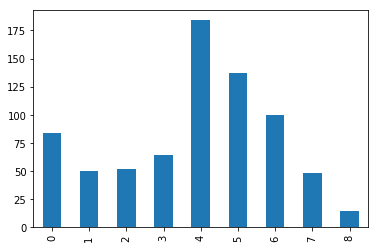

In [6]:
#check the distribution of rating values
#df['Priority'].value_counts(sort=False).plot.bar()

#use binning to scale data to 0-10 or smaller int range for use as display weight. Run commands below just once 
df['Priority'] = df['Priority'] - 67
df['Priority'] = pd.qcut(df['Priority'], 12, labels=False, duplicates='drop')
#plot to confirm binning success
df['Priority'].value_counts(sort=False).plot.bar()

In [7]:
#make some year nodes and replace oldest years with label
df[['Year', 'MM', 'DD']] = df['PublicationDate'].str.split('-', expand=True)
df.sort_values(['PublicationDate'], ascending=False, inplace=True)
df = df.reset_index(drop=True)
#just ignore the SettingWithCopyWarning
df.Year.iloc[677:] = 'Pre-2008 Crisis'

df.tail(5)

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Title,tags,quote,description,Links,cpub,PublicationDate,wtkURL,ArticleId,Priority,Summary_ref_links,Note_links,NERs,NERsMod,NERseek,Year,MM,DD
729,Buffett warns on investment 'time bomb',"['governmentcorruption', ' corporatecorruption...",Mr Buffett argues that such highly complex fin...,The rapidly growing trade in derivatives poses...,http://news.bbc.co.uk/2/hi/2817995.stm,BBC,2003-03-04,https://www.wanttoknow.info/a-buffett-warns-in...,4238,4,[''],['http://www.google.com/publicdata/explore?ds=...,"[('billions of dollars', 'MONEY'), ('Long-Term...","{'billions of dollars': 'MONEY', 'LongTerm Cap...","['Warren Buffett', 'Buffett']",Pre-2008 Crisis,03,04
730,The War On Waste,"['war', ' governmentcorruption', ' financial',...","""According to some estimates we cannot track $...","On Sept. 10 [2001], Secretary of Defense Donal...",http://www.cbsnews.com/stories/2002/01/29/even...,CBS,2002-01-29,https://www.wanttoknow.info/a-2.3-trilliions-m...,846,8,[''],['http://www.personalgrowthcourses.net/video/t...,"[('\r\n ', 'ORG'), ('more than $48 billion', ...","{'Nothing': 'ORG', 'more than 48 billion': 'MO...","['Rumsfeld', 'Inspector General', 'Donald Rums...",Pre-2008 Crisis,01,29
731,Congressional Testimony of DOD Inspector Gener...,"['war', ' governmentcorruption', ' financial',...",Department-level accounting adjustment entries...,"Statement of Robert J Lieberman, Deputy Inspec...",http://www.dodig.osd.mil/Audit/reports/fy01/01...,Department of Defense Inspector Generals Website,2001-05-08,https://www.wanttoknow.info/a-congressional-te...,848,0,[''],[''],"[('Army', 'ORG'), ('2000', 'CARDINAL'), ('the ...","{'Army': 'ORG', '2000': 'CARDINAL', 'the Subco...","['the Office of Management and Budget', 'Depar...",Pre-2008 Crisis,05,08
732,IMF's four steps to damnation,"['governmentcorruption', ' corporatecorruption...",the Bank's 'investigation' involves little mor...,"Joseph Stiglitz, ex-chief economist of the Wor...",http://www.guardian.co.uk/business/2001/apr/29...,The Guardian,2001-04-28,https://www.wanttoknow.info/a-imfs-four-steps-...,5323,7,[''],['http://www.wanttoknow.info/johnperkinseconom...,"[('the World Trade Organisation', 'ORG'), (""th...","{'the World Trade Organisation': 'ORG', ""the W...","['International Monetary Fund', 'the World Ban...",Pre-2008 Crisis,04,28
733,Coruscating criticism of the free market ideol...,"['governmentcorruption', ' financial']","The insider says there's a ""one-size-fits-all""...",GREG PALAST: Protesters say that what we have ...,http://news.bbc.co.uk/2/hi/events/newsnight/13...,BBC,2001-04-27,https://www.wanttoknow.info/a-coruscating-crit...,4322,5,[''],['http://www.youtube.com/watch?feature=player_...,"[('BBC', 'ORG'), ('IMF', 'ORG'), ('the World B...","{'BBC': 'ORG', 'IMF': 'ORG', 'the World Bank':...","['IMF', 'the World Bank', 'Joseph Stiglitz']",Pre-2008 Crisis,04,27


In [8]:
df = df[['Title', 'tags', 'quote', 'description', 'Links', 'cpub', 'PublicationDate', 'Year', 'wtkURL', 'Priority', 'ArticleId']]

#convert tags list column to kumu specification for export 
df['tags'] = df['tags'].astype(str).apply(lambda t: t.strip('['))
df['tags'] = df['tags'].astype(str).apply(lambda u: u.strip(']'))
df['tags'] = df['tags'].str.replace(',', '|')
df['tags'] = df['tags'].str.replace('\'', '')

df.columns = ['Label', 'Tags', 'Quote', 'Description', 'PublisherURL', 'Publisher', 'Date', 'Year', 'SummaryURL', 'Weight', 'ArticleId']
df.insert(loc=1, column='Type', value="Report", allow_duplicates=True)
df = df.drop_duplicates(subset=['Label'])

In [9]:
#make some correctly shaped node element frames and append to main dataframe

plist=[]
p = df['Publisher'].unique()
for i in p:
    plist.append([i, "NewsSource", '','','','','','','','','',''])
dfplist=pd.DataFrame(plist,columns=['Label', 'Type', 'Tags', 'Quote', 'Description', 'PublisherURL', 'Publisher', 'Date', 'Year', 'SummaryURL', 'Weight', 'ArticleId'])

L2=[]
g = EEdgeDF['To'].unique()
for i in g:
    L2.append([i,'','','',"Named entity identified by SpaCy NER",'','','','','','',''])
dfL2=pd.DataFrame(L2,columns=['Label', 'Type', 'Tags', 'Quote', 'Description', 'PublisherURL', 'Publisher', 'Date', 'Year', 'SummaryURL', 'Weight', 'ArticleId'])
dfENTed = dfENTed.drop_duplicates(subset=['Entity'])
Edict = pd.Series(dfENTed.E_Type.values,index=dfENTed.Entity).to_dict()
dfL2['Type'] = dfL2['Label'].map(Edict)
dfL2['Type'] = dfL2['Type'].astype(str).apply(lambda r: r.replace("'", ''))

dfL2 = dfL2.append(dfplist,ignore_index=True)

L3 = []
tmf = df['Year'].unique()
for i in tmf:
    L3.append([i, "Timeframe", '','','','','','','','','',''])
dfL3=pd.DataFrame(L3,columns=['Label', 'Type', 'Tags', 'Quote', 'Description', 'PublisherURL', 'Publisher', 'Date', 'Year', 'SummaryURL', 'Weight', 'ArticleId'])

dfL3 = dfL3.append(dfL2,ignore_index=True)

df[['Weight', 'ArticleId']] = df[['Weight', 'ArticleId']].astype('object', copy=False)
elements = pd.concat([df, dfL3],ignore_index=True)
elements = elements.drop('ArticleId', axis=1)
elements.tail()

,Label,Type,Tags,Quote,Description,PublisherURL,Publisher,Date,Year,SummaryURL,Weight
1135,Harpers magazine,NewsSource,,,,,,,,,
1136,Comptroller General of the United States,NewsSource,,,,,,,,,
1137,Seattle Post-Intelligencer,NewsSource,,,,,,,,,
1138,Government Accountability Office,NewsSource,,,,,,,,,
1139,Department of Defense Inspector Generals Website,NewsSource,,,,,,,,,


In [10]:
#make some publisher and time edges to combine with entity edges
dfEdges = df[['Publisher', 'Label']]
dfEdges.columns=['From', 'To']
timedges = df[['Year', 'Label']]
timedges.columns=['From', 'To']

connects = pd.concat([dfEdges, EEdgeDF],ignore_index=True)
connections = pd.concat([connects, timedges],ignore_index=True)
connections.tail()

,From,To
3356,Pre-2008 Crisis,Buffett warns on investment 'time bomb'
3357,Pre-2008 Crisis,The War On Waste
3358,Pre-2008 Crisis,Congressional Testimony of DOD Inspector Gener...
3359,Pre-2008 Crisis,IMF's four steps to damnation
3360,Pre-2008 Crisis,Coruscating criticism of the free market ideol...


In [11]:
#a final check to make sure everything looks okay
elements.head(5)

,Label,Type,Tags,Quote,Description,PublisherURL,Publisher,Date,Year,SummaryURL,Weight
0,"No CEO should earn 1,000 times more than a reg...",Report,incomeinequality| corporatecorruption,These revelations come thanks to a new federal...,"The CEO of Marathon Petroleum, Gary Heminger, ...",https://www.theguardian.com/business/2018/mar/...,The Guardian,2018-03-18,2018,https://www.wanttoknow.info/a-no-ceo-should-ea...,7
1,One thing Democrats and Republicans apparently...,Report,governmentcorruption| corporatecorruption| f...,Why would more than one-third of the Senate De...,Next week marks the 10th anniversary of the ru...,http://www.latimes.com/opinion/op-ed/la-oe-day...,Los Angeles Times,2018-03-09,2018,https://www.wanttoknow.info/a-one-thing-democr...,4
2,Kept out: How banks block people of color from...,Report,incomeinequality| corporatecorruption| finan...,Fifty years after the federal Fair Housing Act...,Fifty years after the federal Fair Housing Act...,http://www.chicagotribune.com/news/sns-bc-us--...,Chicago Tribune,2018-02-16,2018,https://www.wanttoknow.info/a-kept-out-how-ban...,3
3,The 1% grabbed 82% of all wealth created in 2017,Report,incomeinequality,More than $8 of every $10 of wealth created la...,More than $8 of every $10 of wealth created la...,http://money.cnn.com/2018/01/21/news/economy/d...,CNN,2018-01-22,2018,https://www.wanttoknow.info/a--1-grabbed-82-al...,4
4,Billionaires Made So Much Money Last Year They...,Report,incomeinequality,"The world now has 2,043 billionaires. The grou...",The global economy created a record number of ...,http://time.com/money/5112462/billionaires-mad...,Time,2018-01-22,2018,https://www.wanttoknow.info/a-billionaires-mad...,4


In [12]:
writer = pd.ExcelWriter("C:\\datasources\\financialnewsmap.xlsx")
elements.to_excel(writer,'Sheet1', index=False)
connections.to_excel(writer,'Sheet2', index=False)
writer.save()